In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


모델 B를 통해 구해진 기업별/연도별 점수 테이블에 아래 가중치 반영 적용

### 가중치 반영

In [ ]:
import pandas as pd

# 데이터 불러오기
file_path = '/content/drive/MyDrive/Kwargs/esg 긍부정도/data.csv'
data = pd.read_csv(file_path)
msci_path = '/content/drive/MyDrive/Kwargs/기관 점수/msci_converted.csv'
msci = pd.read_csv(msci_path)

In [ ]:
# MSCI 점수의 평균 계산
msci_columns = ['2019_score', '2020_score', '2021_score', '2022_score', '2023_score']
msci_mean = msci[msci_columns].mean().mean()

# 텍스트 평가 점수를 조정하는 함수
def adjust_positivity(row, msci_mean, factor):
    for year in range(2019, 2024):
        msci_score = row[f'{year}_score']
        positivity_score = row[f'{year}_positivity']
        deviation = (msci_score - msci_mean) / msci_mean
        adjusted_positivity = positivity_score * (1-factor) + factor * deviation
        row[f'{year}_positivity_adjusted'] = adjusted_positivity
    return row

# 가중치 조정 요인 설정
factor = 0.55

# 데이터 프레임의 각 행에 대해 조정 함수 적용
data_adjusted = data.apply(adjust_positivity, axis=1, msci_mean=msci_mean, factor=factor)

# 결과 확인
data_adjusted.head()

# 조정된 데이터를 저장
data_adjusted.to_csv('/content/drive/MyDrive/Kwargs/esg 긍부정도/data_weight_a.csv', index=False)


### 모델 C 구현

In [ ]:
data_adjusted = '/content/drive/MyDrive/Kwargs/esg 긍부정도/data_weight_a.csv'
data_adjusted = pd.read_csv(data_adjusted)

MSE: 0.11754189218688757
R²: 0.9151122111328074


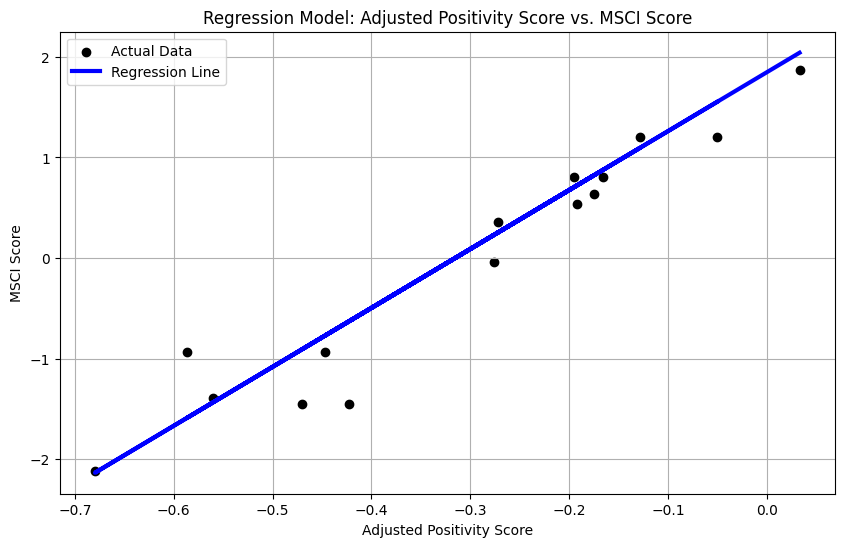

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

# Fill NaN values with the mean of the respective columns for each company
for year in range(2019, 2024):
    data_adjusted[f'{year}_positivity_adjusted'].fillna(data_adjusted[f'{year}_positivity_adjusted'].mean(), inplace=True)
    data_adjusted[f'{year}_score'].fillna(data_adjusted[f'{year}_score'].mean(), inplace=True)

# Preparing the data for regression
X = data_adjusted[[f'{year}_positivity_adjusted' for year in range(2019, 2024)]].values.flatten().reshape(-1, 1)
y = data_adjusted[[f'{year}_score' for year in range(2019, 2024)]].values.flatten()

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create and train the linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Make predictions using the testing set
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("MSE:", mse)
print("R²:", r2)

# Plotting the results
plt.figure(figsize=(10, 6))
plt.scatter(X_test, y_test, color='black', label='Actual Data')
plt.plot(X_test, y_pred, color='blue', linewidth=3, label='Regression Line')
plt.title('Regression Model: Adjusted Positivity Score vs. MSCI Score')
plt.xlabel('Adjusted Positivity Score')
plt.ylabel('MSCI Score')
plt.legend()
plt.grid(True)
plt.show()


### 성능 개선

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import Ridge, Lasso

# Ridge Regression
ridge_model = Ridge(alpha=1.0)
ridge_scores = cross_val_score(ridge_model, X, y, cv=5, scoring='r2')
print("Ridge Regression R² scores:", ridge_scores)
print("Mean R²:", ridge_scores.mean())

# Lasso Regression
lasso_model = Lasso(alpha=0.1)
lasso_scores = cross_val_score(lasso_model, X, y, cv=5, scoring='r2')
print("Lasso Regression R² scores:", lasso_scores)
print("Mean R²:", lasso_scores.mean())


Ridge Regression R² scores: [ 0.21608677  0.72591772  0.70948285  0.787731   -0.23531687]
Mean R²: 0.44078029441402755
Lasso Regression R² scores: [-0.53520773  0.5961501   0.63252077  0.62225815 -0.52499647]
Mean R²: 0.15814496387693305


In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor

# Random Forest Regressor
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_scores = cross_val_score(rf_model, X, y, cv=5, scoring='r2')
print("Random Forest R² scores:", rf_scores)
print("Mean R²:", rf_scores.mean())

# Gradient Boosting Regressor
gb_model = GradientBoostingRegressor(n_estimators=100, random_state=42)
gb_scores = cross_val_score(gb_model, X, y, cv=5, scoring='r2')
print("Gradient Boosting R² scores:", gb_scores)
print("Mean R²:", gb_scores.mean())

# XGBoost Regressor
xgb_model = XGBRegressor(n_estimators=100, random_state=42)
xgb_scores = cross_val_score(xgb_model, X, y, cv=5, scoring='r2')
print("XGBoost R² scores:", xgb_scores)
print("Mean R²:", xgb_scores.mean())


Random Forest R² scores: [ 0.83067252  0.78415581  0.80872476  0.53634522 -0.06400195]
Mean R²: 0.5791792706208388
Gradient Boosting R² scores: [ 0.81619821  0.75277914  0.72995464  0.24058167 -0.16802697]
Mean R²: 0.47429733830541154
XGBoost R² scores: [ 0.6143744   0.76603036  0.77085706  0.2024422  -0.62359044]
Mean R²: 0.3460227174898379


In [ ]:
from sklearn.preprocessing import StandardScaler, PolynomialFeatures

# 데이터 스케일링
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 다항 피처 추가
poly = PolynomialFeatures(degree=2)
X_poly = poly.fit_transform(X_scaled)

# 새로운 피처 엔지니어링
# 추가적인 피처 엔지니어링은 도메인 지식과 데이터를 기반으로 결정됩니다.

# 모델 학습 및 평가 (이전에 시도한 모델에 대해 재시도)
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("MSE:", mse)
print("R²:", r2)


MSE: 0.19278222236383646
R²: 0.8607742628189959


In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

# Random Forest 하이퍼파라미터 튜닝
rf_params = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}
rf_grid = GridSearchCV(RandomForestRegressor(), rf_params, cv=5, scoring='r2')
rf_grid.fit(X, y)
print("Best Random Forest parameters:", rf_grid.best_params_)
print("Best Random Forest R² score:", rf_grid.best_score_)

# Gradient Boosting 하이퍼파라미터 튜닝
gb_params = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 4, 5]
}
gb_grid = GridSearchCV(GradientBoostingRegressor(), gb_params, cv=5, scoring='r2')
gb_grid.fit(X, y)
print("Best Gradient Boosting parameters:", gb_grid.best_params_)
print("Best Gradient Boosting R² score:", gb_grid.best_score_)


Best Random Forest parameters: {'max_depth': 30, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 100}
Best Random Forest R² score: 0.5693593750420318
Best Gradient Boosting parameters: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 300}
Best Gradient Boosting R² score: 0.5079503259352817


In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# 최적 하이퍼파라미터로 랜덤 포레스트 모델 재학습
best_rf_params = {'max_depth': 30, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 100}
best_rf_model = RandomForestRegressor(**best_rf_params, random_state=42)
best_rf_model.fit(X_train, y_train)

# 테스트 세트로 예측 수행
y_pred_rf = best_rf_model.predict(X_test)

# 모델 성능 평가
mse_rf = mean_squared_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

print("Best Random Forest MSE:", mse_rf)
print("Best Random Forest R²:", r2_rf)


Best Random Forest MSE: 0.23083443567334952
Best Random Forest R²: 0.8332932669863657


In [ ]:
from sklearn.ensemble import GradientBoostingRegressor

# 최적 하이퍼파라미터로 그라디언트 부스팅 모델 재학습
best_gb_params = {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 300}
best_gb_model = GradientBoostingRegressor(**best_gb_params, random_state=42)
best_gb_model.fit(X_train, y_train)

# 테스트 세트로 예측 수행
y_pred_gb = best_gb_model.predict(X_test)

# 모델 성능 평가
mse_gb = mean_squared_error(y_test, y_pred_gb)
r2_gb = r2_score(y_test, y_pred_gb)

print("Best Gradient Boosting MSE:", mse_gb)
print("Best Gradient Boosting R²:", r2_gb)


Best Gradient Boosting MSE: 0.19707620540694934
Best Gradient Boosting R²: 0.8576731835426514
